Es de uso extendido en la industria el modelo predictivo de Churn. En él, a partir de un modelo de clasificación, se obtiene la probabilidad de que un socio nos abandone.

Sin embargo, el modelo de churn clásico apunta a modelos de suscripción o contrato donde el cliente abandona a partir de un evento bien determinado (pide la baja del servicio). En el caso de Club Grido, esto no es así ya que el socio se da de alta, comienza a comprar y en cualquier momento puede hacer una compra que sea la última y no volver más. Entonces, cómo sabemos cuando nos abandonó? cómo predecimos que nos va a abandona?

En este notebook se aplica la librería lifetimes que utiliza modelos estadisticos para predecir si un cliente is alive o no. Para ello, toma el comportamiento particular de cada cliente y no es que determina si abandonó o no fijando un período de tiempo arbitrario como podría ser 1 año.

#### Veamos alguna nomenclatura propia de la librería:

- frequency represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.
- T represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
- recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)
- monetary_value represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.

In [77]:
import pandas as pd
import numpy as np
import pyodbc
import os
from lifetimes import BetaGeoFitter
import matplotlib.pyplot as plt
import seaborn as sns
import sidetable as stb
import math

from datetime import datetime as dt

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

#### Importo datos

In [49]:
DB = {'servername': '',
      'database': '',
      'usuario' :'',
      'contraseña':'',
      'Encrypt':'yes',
      'TrustServerCertificate':'no',
      'Connection Timeout':'30'}

# create the connection
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] +\
                      ';UID=' + DB['usuario'] + ';PWD='+ DB['contraseña'] + ';Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30')

# query db
sql = """
SELECT
sc.CustomerId, 
ISNULL(DATEDIFF(DAY,min(s.SaleDate),getdate()),0) 'T',
ISNULL(DATEDIFF(DAY,min(s.SaleDate),max(s.SaleDate)),0) 'recency',
COUNT(DISTINCT CONVERT(DATE,s.SaleDate)) -1 'frequency'

FROM dbo.SaleCustomer sc
INNER JOIN dbo.Sale s ON s.SaleId=sc.SaleId
WHERE s.SaleDate >= DATEADD(year,-1,CONVERT(DATE,getdate()))

GROUP BY sc.CustomerId
"""
df = pd.read_sql(sql, conn)
df.head()

,CustomerId,T,recency,frequency
0,FDA6A364-4A62-C5E0-EBA8-08D6897BF82F,365,349,22
1,7A3ABCD1-85F8-C819-F510-08D6EA5282E9,292,224,12
2,072A0863-EEC3-C280-D0A7-08D7C2DC2CA5,335,310,4
3,77A88836-5701-C7AB-DF3C-08D702FE9148,300,282,2
4,4CD637D7-248B-C49B-D409-08D562B6B355,256,56,1


In [50]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(df['frequency'], df['recency'], df['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2725551 subjects, a: 0.22, alpha: 35.13, b: 2.71, r: 0.89>


Ahora, ploteamos el gráfico Recency vs Frecuency donde tenemos los mejores clientes en el cuadrante de abajo a la derecha ya que son los clientes más antiguos y que más compraron.

Arriba a la derecha están los clientes que compraron mucho rápidamente y hace mucho que no compran.

C:\Users\pnovero\Anaconda3\lib\site-packages\lifetimes\fitters\beta_geo_fitter.py:256: RuntimeWarning: overflow encountered in double_scalars
  denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((alpha + T) / (alpha + recency)) ** (r + x)


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

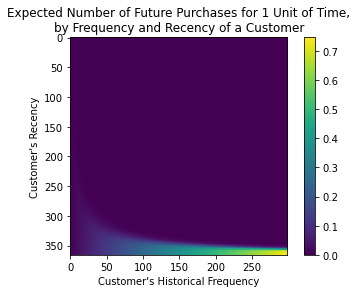

In [4]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

Ahora veremos la probabilidad de seguir Alive de un socio dentro de una matriz recency vs frequency

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

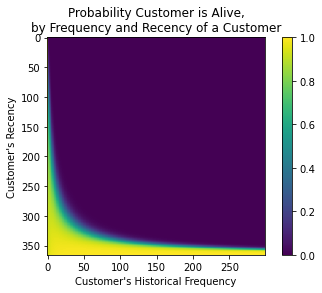

In [5]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

Ahora haremos un ranking de acuerdo a la cantidad de compras expected para cada socio en el próximo mes

In [51]:
t = 30 #es una unidad de tiempo, si uso meses en todas las variables, entonces t es en meses
df['prob_alive'] = bgf.conditional_probability_alive(df['frequency'], df['recency'], df['T'])
df.sort_values(by='prob_alive').tail(5)

,CustomerId,T,recency,frequency,prob_alive
1510094,45290F43-93E5-C527-1AD9-08D5725C8870,342,0,0,1.0
1510096,7F702A4D-A943-C035-D36B-08D667B52F85,5,0,0,1.0
1510099,F66B2F72-6CBC-CD8A-84F4-08D65A8BB192,188,0,0,1.0
1510879,8B11CF25-B19E-CAC7-0A48-08D301A2A674,260,0,0,1.0
2725550,EE4EBDFE-C42D-C0DC-56D8-08D5497E8E78,354,0,0,1.0


In [52]:
t = 30 #es una unidad de tiempo, si uso meses en todas las variables, entonces t es en meses
df['cant_compras_mes_sig'] = bgf.conditional_expected_number_of_purchases_up_to_time(t,df['frequency'], df['recency'], df['T'])
df.sort_values(by='cant_compras_mes_sig').tail(5)

,CustomerId,T,recency,frequency,prob_alive,cant_compras_mes_sig
676764,A0A0403F-B9C1-CB22-7013-08D2F1F79C18,364,362,275,0.996825,20.505654
2421426,169E85D8-FF29-CC1F-1DDB-08D2618144D1,365,363,278,0.996823,20.677170
221300,77DD93FC-57D6-C43B-8220-08D30B035344,365,363,283,0.996799,21.047365
253562,D5E9B992-D6D0-C551-F91A-08D9E696ABCB,162,160,147,0.993348,22.005982
2529512,FCAB6C32-CB9D-C43C-ACB0-08D8A2D0C9DA,364,362,298,0.996710,22.212498


Assesing that the model is correct

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

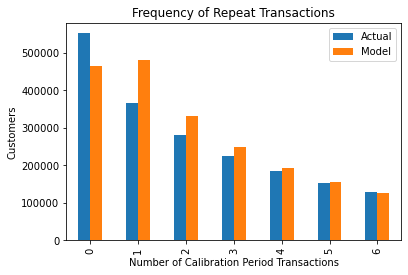

In [8]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [53]:
df['prob_churn'] = np.where(df['prob_alive']== 1, 1- df.cant_compras_mes_sig, 1 - df.prob_alive)

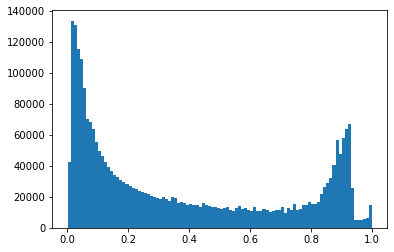

In [54]:
plt.hist(df.prob_churn,bins=100)
plt.show()

### Traigo último producto consumido por cada socio

In [ ]:
DB = {'servername': '',
      'database': '',
      'usuario' :'',
      'contraseña':'',
      'Encrypt':'yes',
      'TrustServerCertificate':'no',
      'Connection Timeout':'30'}

# create the connection
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] +\
                      ';UID=' + DB['usuario'] + ';PWD='+ DB['contraseña'] + ';Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30')

# query db
sql = """
SELECT sc.CustomerId,max(s.ProductName) 'ProductName'
FROM dbo.Sale s
JOIN dbo.SaleCustomer sc ON sc.SaleId = s.SaleId

JOIN (SELECT sc.CustomerId, CONVERT(DATE,max(s.SaleDate)) 'SaleDate' FROM dbo.Sale s 
JOIN dbo.SaleCustomer sc ON sc.SaleId = s.SaleId
GROUP BY sc.CustomerId) AS tabla_secundaria 
ON tabla_secundaria.CustomerId = sc.CustomerId AND CONVERT(DATE, s.SaleDate) = tabla_secundaria.SaleDate

GROUP BY sc.CustomerId, s.SaleId,CONVERT(DATE,s.SaleDate)
"""
ultimo_producto = pd.read_sql(sql, conn)
ultimo_producto.head()


In [ ]:
ultimo_producto = ultimo_producto.merge(productos[['ProductId','ProductName']],on='ProductId',how='left')
ultimo_producto.shape

In [ ]:
ultimo_producto.head()

In [ ]:
ultimo_producto['producto'] = np.where(ultimo_producto.ProductName.str.contains(" X"), ultimo_producto.ProductName.str.split(" X").str[0],ultimo_producto.ProductName)
ultimo_producto['producto'] = np.where(ultimo_producto.producto.str.contains(" x"), ultimo_producto.producto.str.split(" x").str[0],ultimo_producto.producto)
ultimo_producto.producto.value_counts()

In [ ]:
ultimo_producto.isnull().sum()

In [ ]:
ultimo_producto.fillna('1')[ultimo_producto.producto.str.contains('\?')]

In [ ]:
ultimo_producto.drop(columns=['ProductName', 'linea_producto',
       'familia', 'idCategoria', 'categoria'],inplace=True)

### Importo nombre y mail del socio

In [65]:
DB = {'servername': '',
      'database': '',
      'usuario' :'',
      'contraseña':'',
      'Encrypt':'yes',
      'TrustServerCertificate':'no',
      'Connection Timeout':'30'}

# create the connection
conn = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] +\
                      ';UID=' + DB['usuario'] + ';PWD='+ DB['contraseña'] + ';Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30')

# query db
sql = """

SELECT cpl.CustomerId, sum(cpl.Points) 'Puntos', c.FirstName, c.Email, seg.DaysLastsale,
DATEDIFF(DAY,max(case when cpl.eventTypeCode = 'DiscountPointsByExchange' then cpl.LogDate else '2019-01-01' end),getdate()) 'dias_ult_canje'


FROM dbo.CustomerPointsLog cpl
INNER JOIN dbo.Customer c ON c.CustomerId = cpl.CustomerId
INNER JOIN dbo.clientes_segmentacion_2022 seg ON cpl.CustomerId = seg.CustomerId
GROUP BY cpl.CustomerId, c.FirstName, c.Email, seg.DaysLastsale
"""
datos_socio = pd.read_sql(sql, conn)
datos_socio.head()

,CustomerId,Puntos,FirstName,Email,DaysLastsale,dias_ult_canje
0,273AFE21-79E8-CC3A-AAF6-08D0C0CE8984,6300,Lujan Evangelina,lujantassone@hotmail.com,30.0,1290
1,D1C0D365-6970-C40B-A6E6-08D0BD70A3EB,16470,Jose Antonio,joseamin12@hotmail.com,23.0,941
2,10C29CB8-C4F5-C071-3842-08D0BF4D95AE,0,Luciana Mariela,acolombero@huincacoop.com.ar,NaN,1290
3,DE3B393D-8E46-C831-D611-08D0BF3B6F0A,140,Maria Graciela,escuelaingalfedotbelot@hotmail.com,28.0,1290
4,6ACC86A5-45BC-C851-BE13-08D0BF45D4BD,6050,Carolina Marina,carolmon7@hotmail.com,165.0,1290


In [66]:
datos_socio.DaysLastsale.fillna(1000,inplace=True)

In [68]:
datos_socio['dias_desde_ult_actividad'] = datos_socio[['DaysLastsale','dias_ult_canje']].min(1)

In [71]:
datos_socio.columns

Index(['CustomerId', 'Puntos', 'FirstName', 'Email', 'DaysLastsale',
       'dias_ult_canje', 'dias_desde_ult_actividad'],
      dtype='object')

### Armo el archivo a exportar

In [69]:
socios_enviar_mail = df[df.prob_churn > 0.62]
socios_enviar_mail.shape

(780386, 7)

In [70]:
socios_enviar_mail.columns

Index(['CustomerId', 'T', 'recency', 'frequency', 'prob_alive',
       'cant_compras_mes_sig', 'prob_churn'],
      dtype='object')

In [87]:
#base_exportar = socios_enviar_mail[['CustomerId','prob_alive']].merge(datos_socio[['CustomerId', 'Puntos', 'FirstName', 'Email', 'dias_desde_ult_actividad']], on ='CustomerId',how='left')
base_exportar['Puntos'] = base_exportar['Puntos'].astype('int')
base_exportar['dias_desde_ult_actividad'] = base_exportar['dias_desde_ult_actividad'].astype('int')

In [89]:
max_MB=50
path = r''
base_exportar.to_csv(path,index=False)
tamaño = os.path.getsize(path)/1000000
print(tamaño)
if tamaño > max_MB:
    os.remove(path)
    cantidad_archivos= math.ceil(tamaño/max_MB)
    archivos= np.array_split(base_exportar,cantidad_archivos)
    for idx,archivo in enumerate(archivos):
        path = r'' + str(idx) + '.csv'
        archivo.to_csv(path,index=False)
        print(path)

71.076445
C:/Users/pnovero/Documents/Extractos DW/alta_prob_churn_0.csv
C:/Users/pnovero/Documents/Extractos DW/alta_prob_churn_1.csv


In [88]:
base_exportar.head()

,CustomerId,prob_alive,Puntos,FirstName,Email,dias_desde_ult_actividad
0,074046CF-ED23-C0A2-3C15-08D43763C535,0.100702,13900,Cintia,cintiavero83@gmail.com,171
1,7959737F-6376-C0EE-3A04-08D9BE8520C7,0.259303,2100,Veronica,veroksk1@gmail.com,39
2,7AC2E300-FB1B-C4E2-1A73-08D3268071C9,0.099691,5110,Damian,sarmiento.damian25@gmail.com,136
3,F99CF5BF-1E8E-C683-B70C-08D67BD9BDB8,0.236676,2360,Susana Leonor,luisstea.ls@gmail.com,181
4,53B94A78-5429-C121-098B-08D305B9AF96,1.000000,5900,Marcela,flocaniso@hotmail.com,361
